In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'TRUE'

In [2]:
import deepdish as dd
import numpy as np
import matplotlib.pyplot as plt
from videoreader import VideoReader

from leap_utils.preprocessing import export_boxes, angles, normalize_boxes, detect_bad_boxes_by_angle, fix_orientations
from leap_utils.postprocessing import process_confmaps_simple
from leap_utils.predict import predict_confmaps, load_network
from leap_utils.utils import iswin, ismac, flatten, unflatten
from leap_utils.io import DataLoader



def plotboxes(boxes, bad=None):
    plt.gcf().set_size_inches(20, 20)
    for ii in range(min(64, boxes.shape[0])):
        plt.subplot(8,8,ii+1)
        plt.imshow(boxes[ii,:,:,0])
        plt.xticks([])
        plt.yticks([])
        if bad is not None:
            plt.title(bad[ii])

datename = 'localhost-20180720_182837'
root = '/Volumes/ukme04/#Common/chainingmic/'
network = load_network(root+'/leap/best_model.h5', image_size=[120, 120])

# root = '/Users/janc/Dropbox'
# poses_folder = ''
# video_folder = ''
# tracks_folder = ''
# network = load_network(root+'/best_model.h5', image_size=[120, 120])
dl = DataLoader('io.yaml', root=root)
poses = dl.get('poses', datename)
# poses = dd.io.load(os.path.join(root, poses_folder, datename, datename + poses_suffix))
print(poses.keys())
# vr = VideoReader(os.path.join(root, video_folder, datename, datename + video_suffix))
vr = dl.get('video', datename)
print(vr)
tracks = dl.get('tracks', datename) #dd.io.load(os.path.join(root, tracks_folder, datename, datename + tracks_suffix))
print(dl.path('tracks', datename)) #
# tracks = dd.io.load(os.path.join(root, tracks_folder, datename, datename + tracks_suffix))
# print(tracks.keys())


centers = tracks['centers']    # nframe, channel, fly id, coordinates
tracksR = tracks['lines']
chbb = tracks['chambers_bounding_box']
heads = tracksR[:, 0, :, 0, ::-1]   # nframe, fly id, coordinates
tails = tracksR[:, 0, :, 1, ::-1]   # nframe, fly id, coordinates
heads = heads + chbb[1][0][:]   # nframe, fly id, coordinates
tails = tails + chbb[1][0][:]   # nframe, fly id, coordinates
box_angles = angles(heads, tails)
box_centers = centers[:, 0, :, :]   # nframe, fly id, coordinates
box_centers = box_centers + chbb[1][0][:]
nb_flies = box_centers.shape[1]

Using TensorFlow backend.


[('res', '_poses.h5')]
dict_keys(['bad_boxes', 'confidence', 'fixed_angles', 'fly_frame', 'fly_id', 'frame_numbers', 'positions', 'expID', 'last_saved_batch'])
[('dat', '.mp4'), ('dat.processed', '.mp4')]
/Volumes/ukme04/#Common/chainingmic/dat.processed/localhost-20180720_182837/localhost-20180720_182837.mp4 with 180846 frames of size (920, 912, 3) at 99.99 fps
[('res', '_tracks_fixed.h5'), ('res', '_tracks.h5')]
[('res', '_tracks_fixed.h5'), ('res', '_tracks.h5')]
/Volumes/ukme04/#Common/chainingmic/res/localhost-20180720_182837/localhost-20180720_182837_tracks_fixed.h5


In [3]:
frame_numbers = list(range(800, 1300, 10))
box_centers = box_centers[frame_numbers,...]
box_angles = box_angles[frame_numbers,...]
frames = [frame[:, :, :1] for frame in vr[frame_numbers]]  # keep only one color channel
box_size = [120, 120]
boxes, fly_id, fly_frame = export_boxes(frames, box_centers, box_size=box_size, box_angles=box_angles)
print(boxes.shape)

(100, 120, 120, 1)


In [4]:
confmaps = predict_confmaps(network, normalize_boxes(boxes))
print(confmaps.shape)
positions, confidence = process_confmaps_simple(confmaps)

(100, 120, 120, 12)


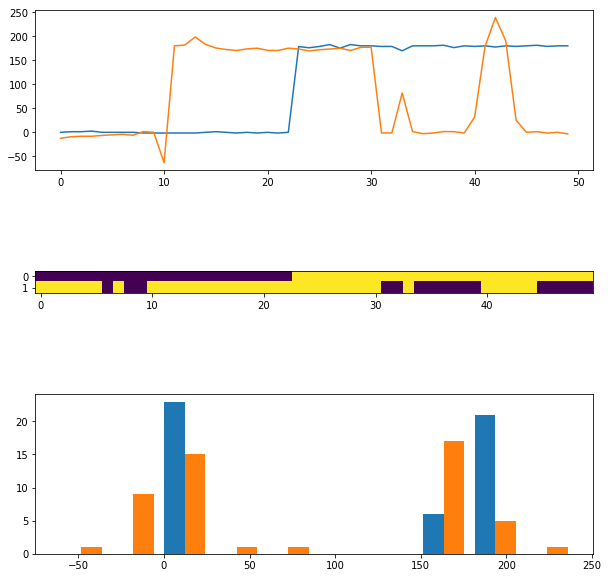

In [5]:
# TODO: make positions self-documenting (named_list), make these args
head_idx = 0
tail_idx = 11
nb_flies = box_angles.shape[1]

newbox_angles, bad_boxes = detect_bad_boxes_by_angle(unflatten(positions[:, head_idx, :], nb_flies),
                                                     unflatten(positions[:, tail_idx, :], nb_flies),
                                                     epsilon=5)
plt.gcf().set_size_inches(10, 10)
plt.subplot(311)
plt.plot(newbox_angles[...,0])
plt.subplot(312)
plt.imshow(bad_boxes[...,0].T)
plt.subplot(313)
plt.hist(newbox_angles[...,0]);

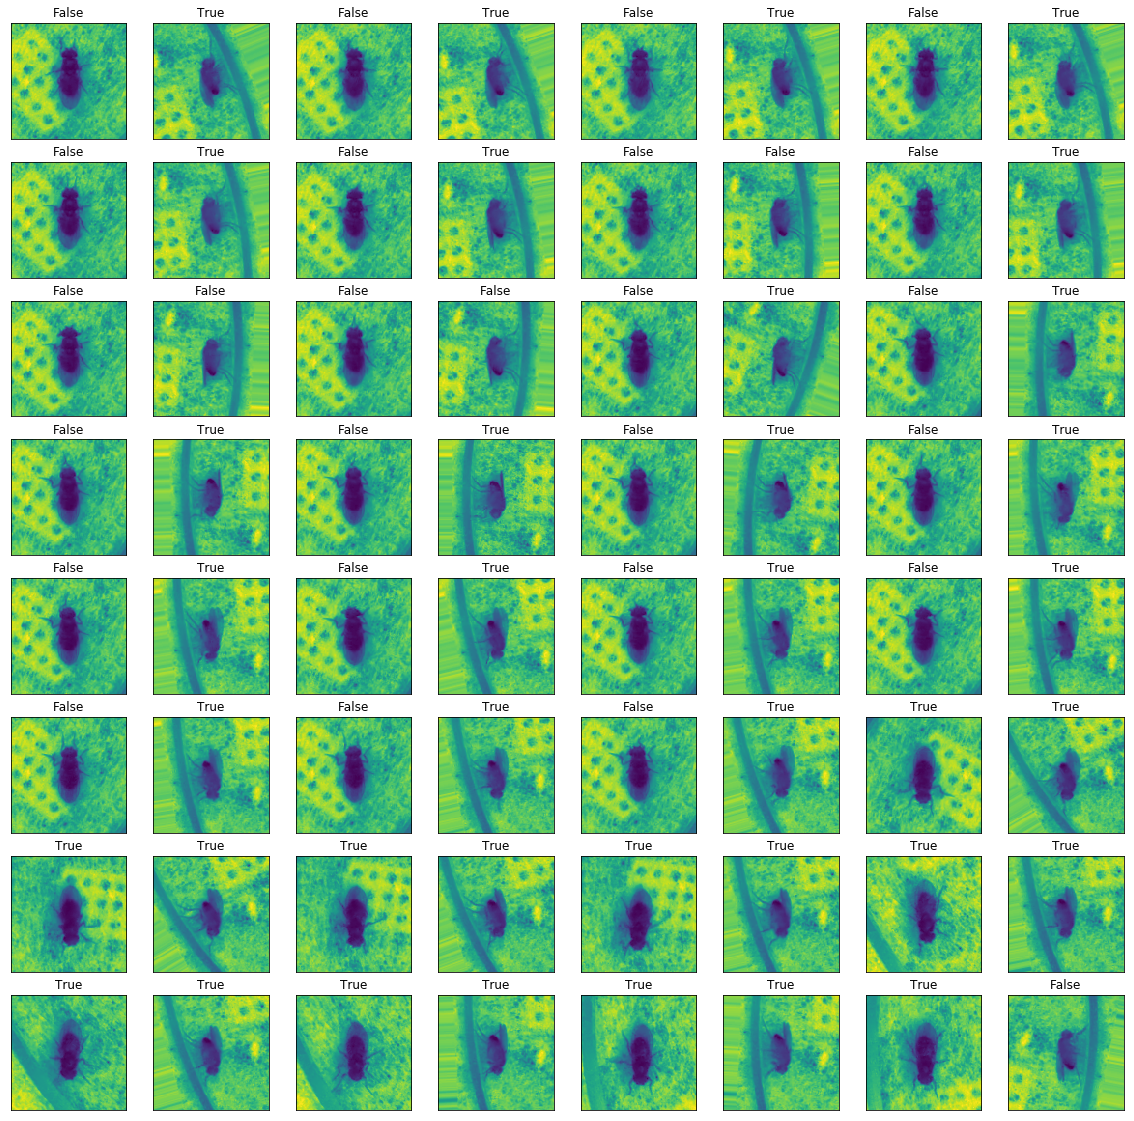

In [6]:
plotboxes(boxes, flatten(bad_boxes[..., 0]))

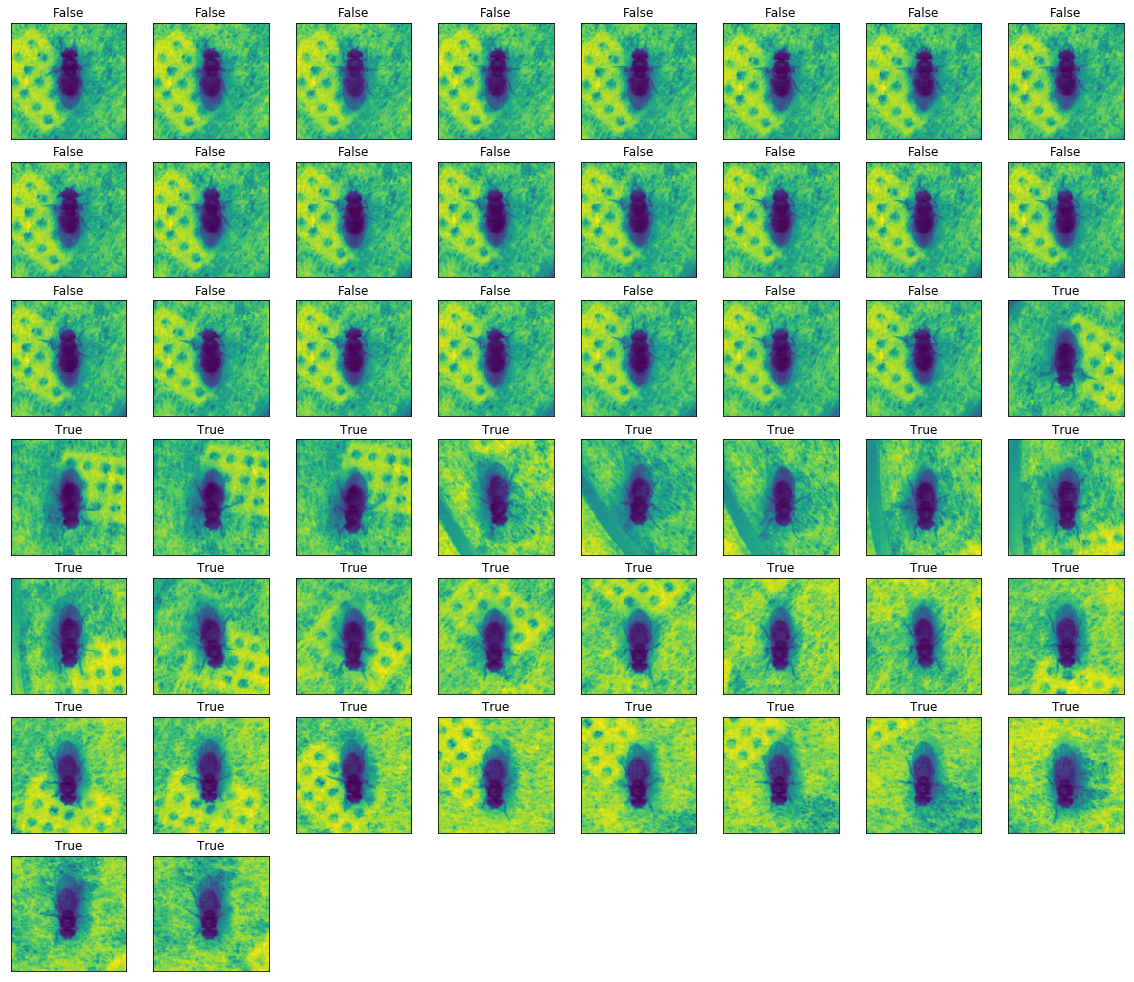

In [7]:
plotboxes(boxes[::2,...], bad_boxes[..., 0, 0])

In [8]:
# from leap_utils.plot import vplay
# vplay(boxes[::2,...])

In [9]:
# FIX ALL
print(newbox_angles.shape)
print(box_angles[600:650,...].shape)
fixed_angles = box_angles + newbox_angles
newboxes, *_ = export_boxes(frames,
                         box_centers,
                         box_size=np.array([120, 120]),
                         box_angles=fixed_angles)
newconfmaps = predict_confmaps(network, normalize_boxes(newboxes))
newpositions, newconfidence = process_confmaps_simple(newconfmaps)

(50, 2, 1)
(0, 2, 1)


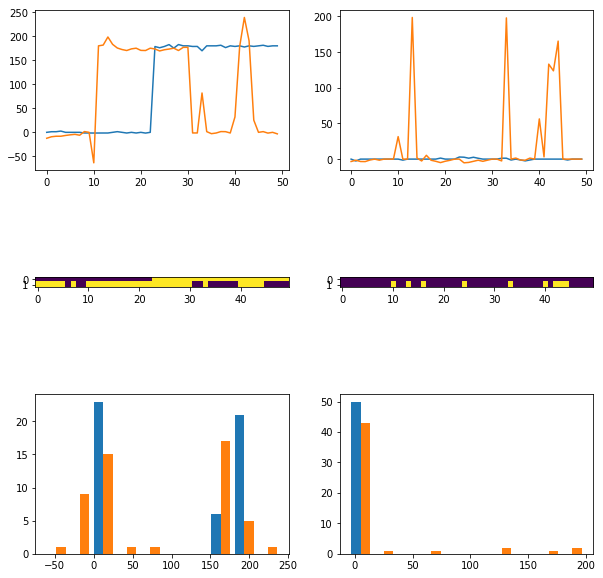

In [10]:
head_idx = 0
tail_idx = 11
new_newbox_angles, new_bad_boxes = detect_bad_boxes_by_angle(unflatten(newpositions[:, head_idx, :], nb_flies),
                                                             unflatten(newpositions[:, tail_idx, :], nb_flies),
                                                             epsilon=5)

plt.gcf().set_size_inches(10, 10)
plt.subplot(321)
plt.plot(newbox_angles[...,0])
plt.subplot(323)
plt.imshow(bad_boxes[...,0].T)
plt.subplot(325)
plt.hist(newbox_angles[...,0]);

plt.subplot(322)
plt.plot(new_newbox_angles[...,0])
plt.subplot(324)
plt.imshow(new_bad_boxes[...,0].T)
plt.subplot(326)
plt.hist(new_newbox_angles[...,0]);

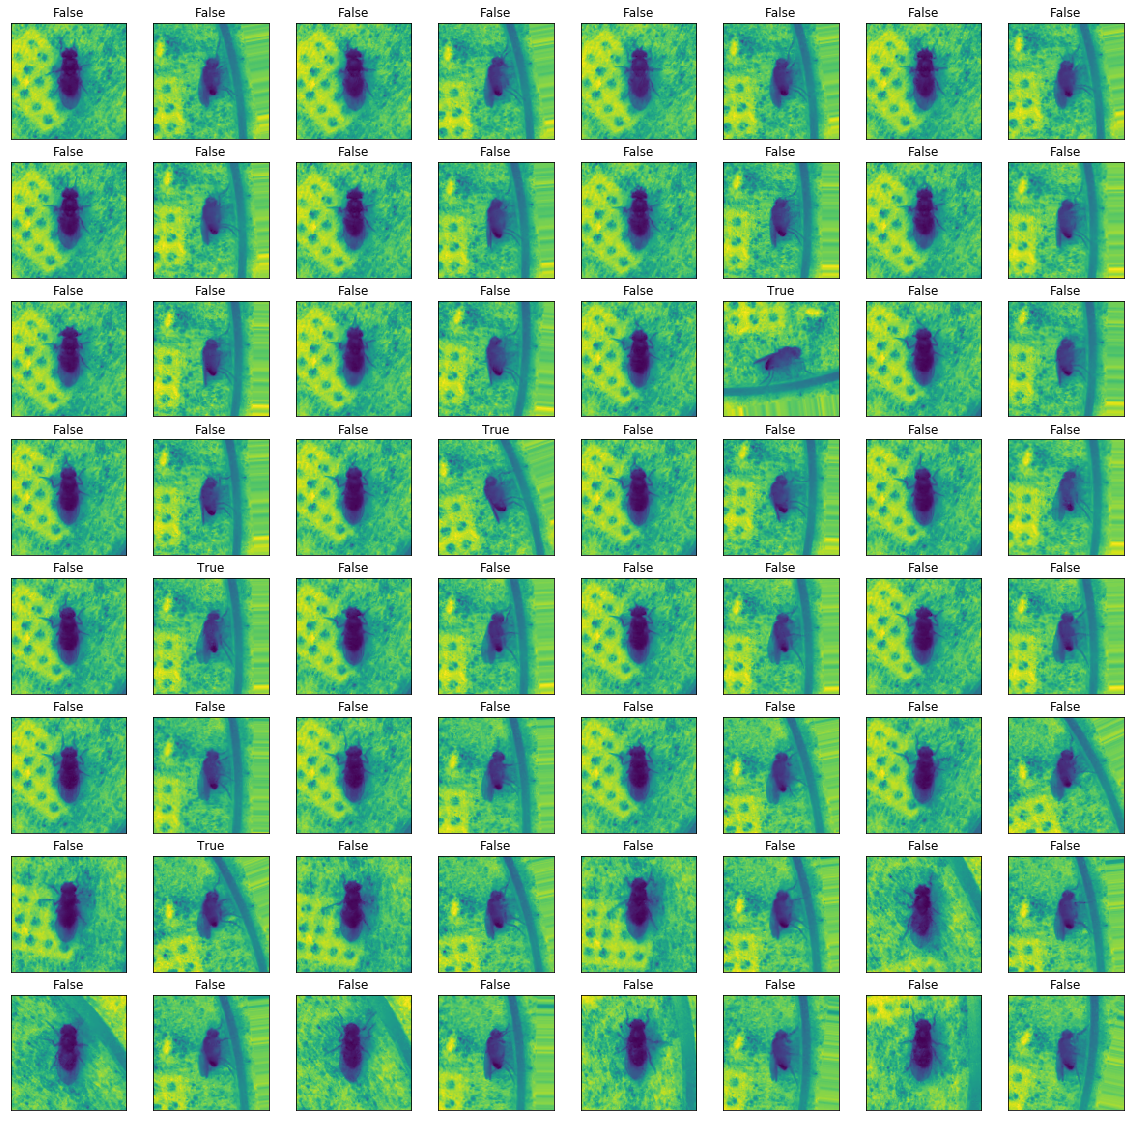

In [11]:
plotboxes(newboxes, flatten(new_bad_boxes[..., 0]))

In [12]:
sub_boxes = np.copy(boxes)
sub_confmaps = np.copy(confmaps)
sub_confidence = np.copy(confidence)
sub_positions = np.copy(positions)
sub_fixed_angles = np.copy(box_angles)

newbox_anglesX, bad_boxesX = detect_bad_boxes_by_angle(unflatten(sub_positions[:, head_idx, :], nb_flies),
                                                     unflatten(sub_positions[:, tail_idx, :], nb_flies),
                                                     epsilon=5)

# bad_boxesX = np.logical_not(bad_boxesX)

bad_frame_idx = np.any(bad_boxesX, axis=1)[:, 0]   # for addressing bad boxes by frame
print(bad_frame_idx)
bad_box_idx = np.repeat(bad_frame_idx, nb_flies)   # for addressing bad boxes by box
print(f"   found {np.sum(bad_boxesX)} cases of boxes with angles above threshold.")
box_angles = box_angles[:bad_boxesX.shape[0], ...]
box_centers = box_centers[:bad_boxesX.shape[0], ...]

sub_fixed_angles[bad_frame_idx, ...] = box_angles[bad_frame_idx, ...] + newbox_anglesX[bad_frame_idx, ...]
sub_boxes[bad_box_idx, ...], *_ = export_boxes([frames[int(idx)] for idx in np.where(bad_frame_idx)[0]],
                                           box_centers[bad_frame_idx, ...],
                                           box_size=np.array([120, 120]),
                                           box_angles=sub_fixed_angles[bad_frame_idx, ...])
sub_confmaps[bad_box_idx, ...] = predict_confmaps(network, normalize_boxes(sub_boxes[bad_box_idx, ...]))
sub_positions[bad_box_idx, ...], sub_confidence[bad_box_idx, ...] = process_confmaps_simple(sub_confmaps[bad_box_idx, ...])

[ True  True  True  True  True  True False  True False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
   found 61 cases of boxes with angles above threshold.


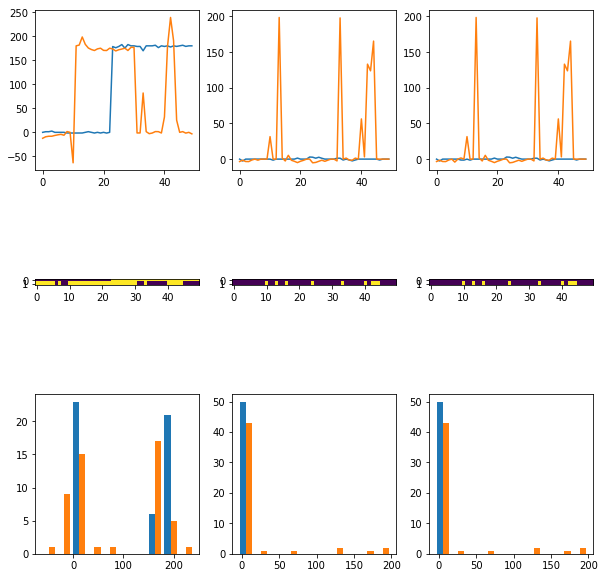

In [13]:
sub_newbox_angles, sub_bad_boxes = detect_bad_boxes_by_angle(unflatten(sub_positions[:, head_idx, :], nb_flies),
                                                             unflatten(sub_positions[:, tail_idx, :], nb_flies),
                                                             epsilon=5)

plt.gcf().set_size_inches(10, 10)
plt.subplot(331)
plt.plot(newbox_angles[...,0])
plt.subplot(334)
plt.imshow(bad_boxes[...,0].T)
plt.subplot(337)
plt.hist(newbox_angles[...,0]);

plt.subplot(332)
plt.plot(new_newbox_angles[...,0])
plt.subplot(335)
plt.imshow(new_bad_boxes[...,0].T)
plt.subplot(338)
plt.hist(new_newbox_angles[...,0]);

plt.subplot(333)
plt.plot(sub_newbox_angles[...,0])
plt.subplot(336)
plt.imshow(sub_bad_boxes[...,0].T)
plt.subplot(339)
plt.hist(sub_newbox_angles[...,0]);

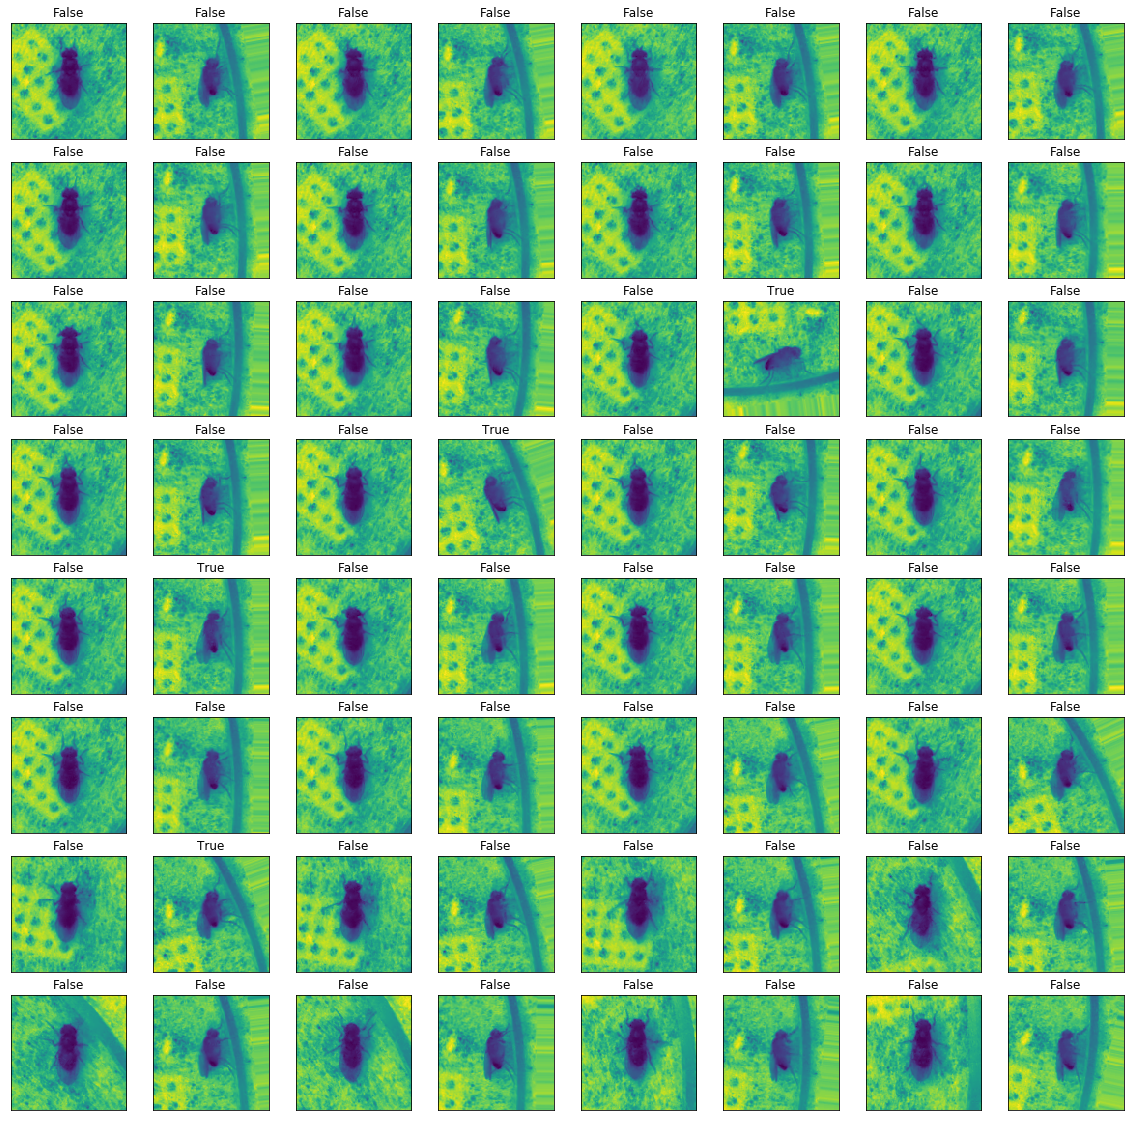

In [14]:
plotboxes(sub_boxes, flatten(sub_bad_boxes[..., 0]))

In [ ]:

vr = video
frames = fr[framenumers]
boxes = get_boxes(frames, fixed_centers_from_tracks, fixed_angles_from_poses)# get boxes
# predict confmaps